In [115]:
import os
current_directory = os.getcwd()
if os.path.basename(os.getcwd()) != "neural-spx-vix-calibration":
    # Get the parent directory
    parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
    # Change the working directory to the parent directory
    os.chdir(parent_directory)
print(os.getcwd())

C:\Users\Martial\neural-spx-vix-calibration


In [116]:
import json
import torch
import time
import numpy as np
import importlib
import matplotlib.pyplot as plt
import src.checkpoint
from src.smile import Datetime
from src.data import load_dataset
from src.generator import GeneratorIto
from src.train_utils import train
from src.train_utils import wrap_loss_func
from src.train_utils import prepare_data
from src.train_utils import checkpoint_func
from src.vix import compute_VIX2_nested
import glob
from data.expiry_selection import get_expiries
from src.data import load_dataset
from src.generator import GeneratorIto
from src.train_utils import train
from src.train_utils import wrap_loss_func
from src.train_utils import prepare_data
from src.train_utils import checkpoint_func
import datetime as dt

In [117]:
TAU = torch.tensor(30 / 365, device="cuda:0" if torch.cuda.is_available() else "cpu")

In [118]:
date = dt.date(2021, 10, 1)
# date = dt.date(2025, 12, 1)
model_file = ".".join(('src', "my_model"))


chosen_threshold = 21 * 6
maturities = {
    'spx': [dt.datetime.strftime(t, "%Y/%m/%d") for t in get_expiries(root="SPX", date=date, n_day_threshold=chosen_threshold + 30)],
    'vix': [dt.datetime.strftime(t, "%Y/%m/%d") for t in get_expiries(root="VIX", date=date, n_day_threshold=chosen_threshold)],
}

params = {
    "batch_size" : 150000,
    "dt" : 0.5,
    "w_fVIX" : 30,
    "w_CVIX" : 2,
    "w_SPX" : 3
}

my_model = importlib.import_module(model_file)


In [119]:
date_str = date.strftime("%Y/%m/%d")
data = load_dataset(date_str)
smiles, maturities, fSPX = prepare_data(data, date_str, maturities)

dt = torch.tensor(params["dt"] / 365)
GEN = GeneratorIto(dt, my_model.V_AND_MUY(my_model.MODEL), fSPX)

model, epoch = src.checkpoint.load_last_checkpoint(my_model.MODEL)

Loading checkpoints/spx_vix_small\158-1209-154735-282470.ckpt
checkpoints/spx_vix_small\158-1209-154735-282470.ckpt loaded. epoch : 159, l : 2.8247


In [120]:
files = glob.glob("checkpoints/spx_vix_small/*.ckpt")
def key(file):
    loss = file.split("-")[-1]
    loss = loss[:-5]
    return float(loss)
file = min(files, key=key)
file = files[50]
file

'checkpoints/spx_vix_small\\144-1209-154501-309640.ckpt'

In [121]:
model, epoch = src.checkpoint.load(file, my_model.MODEL)

Loading checkpoints/spx_vix_small\144-1209-154501-309640.ckpt
checkpoints/spx_vix_small\144-1209-154501-309640.ckpt loaded. epoch : 145, l : 3.0964


In [122]:
t, T0, loss_func = wrap_loss_func(date_str, params, smiles, maturities, GEN, dt, fSPX)

In [123]:
with torch.no_grad():
    _, output = loss_func(0, trajectories=True)
smiles = output["smiles"]

In [124]:
# sub_batch_size, batch_size_nested = 20_000, 10_000
sub_batch_size, batch_size_nested = 200, 100
k = 10

In [125]:
from src.bs import implied_vol
from src.smile import Smile

def compute_smile_vix_nested(maturity, VIX2_nested, vix_smile):
    strikes = vix_smile.strikes
    VIX = 100 * VIX2_nested.sqrt()
    fVIX = VIX.mean()
    t0 = torch.tensor(0.)
    CVIX = (VIX - strikes).relu().mean(axis=0)
    PVIX = (strikes - VIX).relu().mean(axis=0)
    t = torch.tensor(maturity.t, device="cuda:0" if torch.cuda.is_available() else "cpu")
    IVIX = implied_vol(fVIX, t0, t, strikes, CVIX, PVIX).cpu()
    smile = Smile("VIX model", maturity, {
        "strikes" : strikes,
        "fwd" : fVIX,
        "fwd_ask" : fVIX,
        "fwd_bid" : fVIX,
        "mids" : IVIX,
        "asks" : IVIX,
        "bids" : IVIX,
        "calls" : CVIX,
        "puts" : PVIX
    })
    return VIX, smile

In [126]:
for i, maturity in enumerate(maturities["all"]):
    if maturity in maturities["vix"]:
        print("Computing VIX for maturity =", maturity)
        XYi = output["XY"][i + 1]
        j = maturities["all"].index(maturity.plus_30d())
        Rij = output["R"][j + 1] - output["R"][i + 1]
        VIX2_nested = compute_VIX2_nested(GEN, maturity, maturity.plus_30d(), 
                                          TAU, XYi, sub_batch_size, 
                                          batch_size_nested, k)
        VIX_nested, smile_vix_nested = compute_smile_vix_nested(maturity, 
                                                                VIX2_nested, 
                                                                smiles[maturity]["vix"]["market"])
        smiles[maturity]["vix_nested"] = {
            "model" : smile_vix_nested,
            "market" : smiles[maturity]["vix"]
        }

Computing VIX for maturity = 2021/10/20
Computing VIX for maturity = 2021/11/17


C:\Users\Martial\neural-spx-vix-calibration\.venv\Lib\site-packages\torchsde\_brownian\brownian_interval.py:599: UserWarning: Should have ta>=t0 but got ta=0.12876711785793304 and t0=0.12876712328767123.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")


Computing VIX for maturity = 2021/12/22
Computing VIX for maturity = 2022/01/19
Computing VIX for maturity = 2022/02/16


C:\Users\Martial\neural-spx-vix-calibration\.venv\Lib\site-packages\torchsde\_brownian\brownian_interval.py:599: UserWarning: Should have ta>=t0 but got ta=0.37808218598365784 and t0=0.3780821917808219.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")
C:\Users\Martial\neural-spx-vix-calibration\.venv\Lib\site-packages\torchsde\_brownian\brownian_interval.py:608: UserWarning: Should have tb<=t1 but got tb=0.46027398109436035 and t1=0.4602739726027397.
  warnings.warn(f"Should have {tb_name}<=t1 but got {tb_name}={tb} and t1={self._end}.")


Computing VIX for maturity = 2022/03/15


In [127]:
def plot(self, color=None, legend=True):
    with torch.no_grad():
        plt.plot(self.strikes.cpu(), self.mids.cpu(), color=color, 
                 label=f"{self.name} mid implied vol.")
        plt.scatter(self.strikes.cpu(), self.mids.cpu(), marker="x", s=20, color=color)

        plt.fill_between(self.strikes.cpu(), self.bids.cpu(), self.asks.cpu(), color=color, alpha=0.5, label="bid-ask")

        plt.axvline(self.fwd.cpu(), color=color, linestyle="--",
                    label=f"{self.name} future")
        plt.xlabel("Strike")
        plt.ylabel("Implied volatility")
        if legend:
            plt.legend()
        plt.title(self.name)

In [128]:
def plot_smile(smile_model, smile_market):
    strikes = smile_model.strikes.cpu()
    with torch.no_grad():
        plt.plot(strikes, smile_model.mids.cpu(), color="black", label=f"model implied vol")
        plt.scatter(strikes, smile_model.mids.cpu(), marker="x", s=20, color="black")
        plt.axvline(smile_model.fwd.cpu(), color="black", linestyle="--", label=f"model future")

        plt.plot(strikes, smile_market.mids.cpu(), color="red", label=f"market implied vol")
        plt.scatter(strikes, smile_market.mids.cpu(), marker="x", s=20, color="red")
        plt.axvline(smile_market.fwd.cpu(), color="red", linestyle="dashdot", label=f"market future")
        plt.fill_between(strikes, smile_market.bids.cpu(), smile_market.asks.cpu(), color="red", alpha=0.5, label="market bid-ask")

        plt.xlabel("Strike")
        plt.ylabel("Implied volatility")
        plt.legend()
        
def plot_smile_vix(smile_model, smile_market, simle_lstsq):
    strikes = smile_model.strikes.cpu()
    with torch.no_grad():
        plt.plot(strikes, smile_model.mids.cpu(), color="black", label=f"model implied vol (nested mc)")
        plt.scatter(strikes, smile_model.mids.cpu(), marker="x", s=20, color="black")
        plt.axvline(smile_model.fwd.cpu(), color="black", linestyle="--", label=f"model future (nested mc)")

        plt.plot(strikes, smile_market.mids.cpu(), color="red", label=f"market implied vol")
        plt.scatter(strikes, smile_market.mids.cpu(), marker="x", s=20, color="red")
        plt.axvline(smile_market.fwd.cpu(), color="red", linestyle="dashdot", label=f"market future")
        plt.fill_between(strikes, smile_market.bids.cpu(), smile_market.asks.cpu(), color="red", alpha=0.5, label="market bid-ask")

        #plt.plot(strikes, simle_lstsq.mids.cpu(), color="green", label=f"model implied vol (lstsq)")
        #plt.scatter(strikes, simle_lstsq.mids.cpu(), marker="x", s=20, color="green")
        #plt.axvline(simle_lstsq.fwd.cpu(), color="green", linestyle="dashdot", label=f"model future (lstsq)")
        
        plt.xlabel("Strike")
        plt.ylabel("Implied volatility")
        plt.legend()
        
        
def plot_comparison(smile_lstsq, smile_nested):
    strikes = smile_lstsq.strikes.cpu()
    with torch.no_grad():
        plt.plot(strikes, smile_nested.mids.cpu(), color="black", label=f"nested implied vol")
        plt.scatter(strikes, smile_nested.mids.cpu(), marker="x", s=20, color="black")
        plt.axvline(smile_nested.fwd.cpu(), color="black", linestyle="--", label=f"nested future")

        plt.plot(strikes, smile_lstsq.mids.cpu(), color="green", label=f"least squares vol")
        plt.scatter(strikes, smile_lstsq.mids.cpu(), marker="x", s=20, color="green")
        plt.axvline(smile_lstsq.fwd.cpu(), color="green", label=f"least squares future")

        plt.xlabel("Strike")
        plt.ylabel("Implied volatility")
        plt.legend()

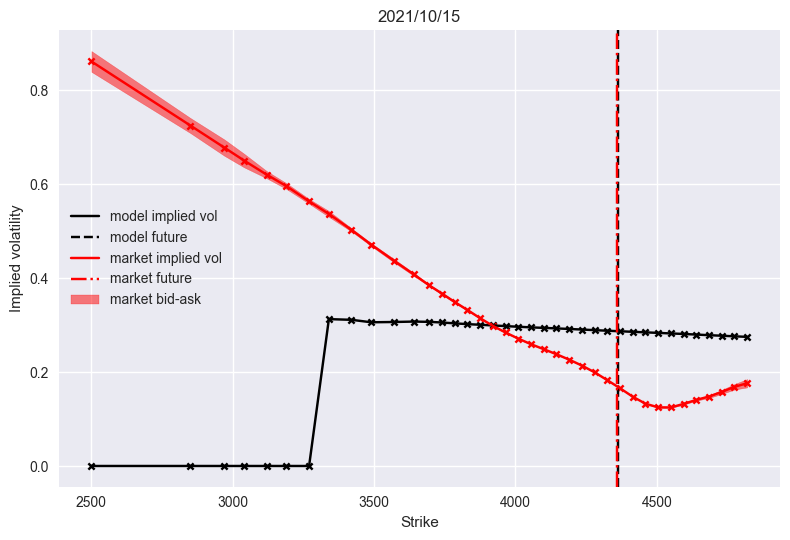

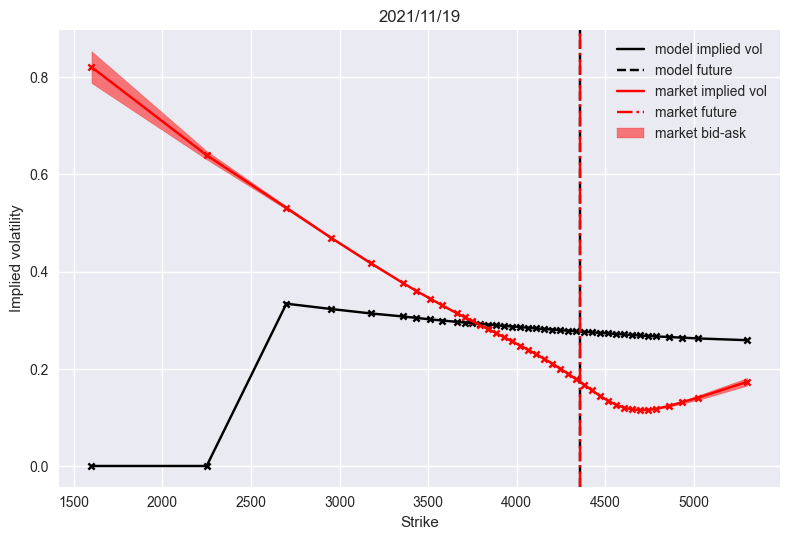

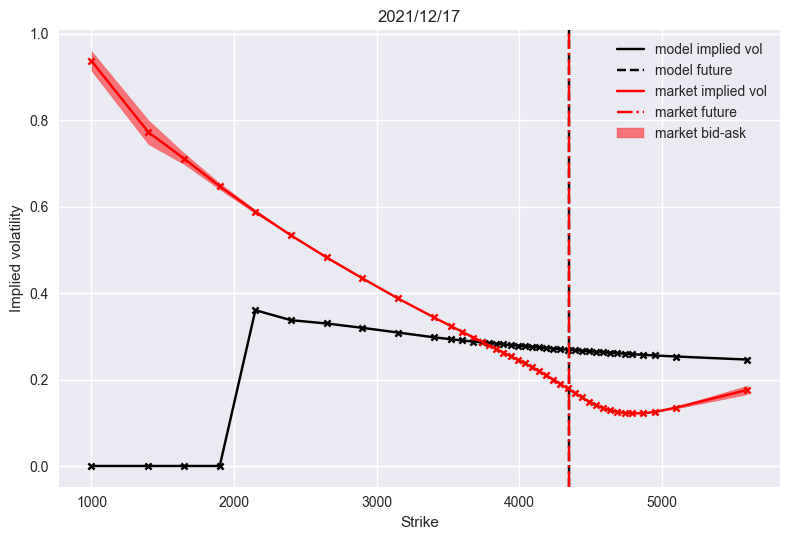

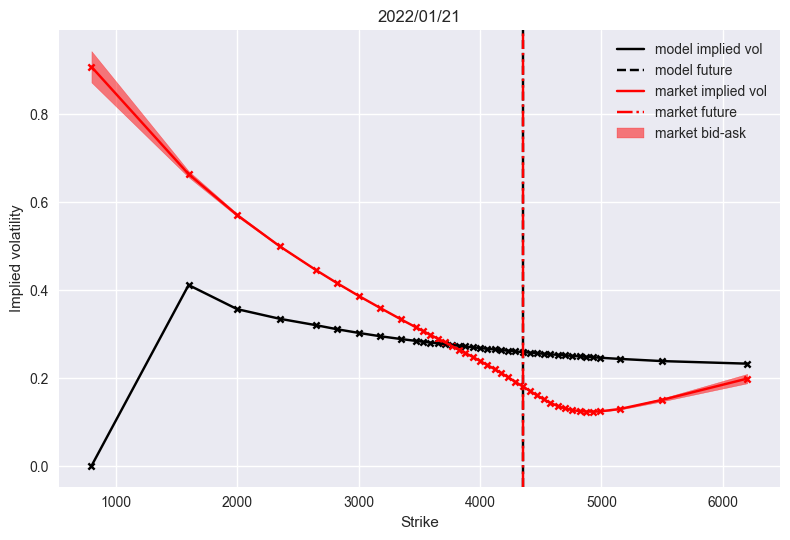

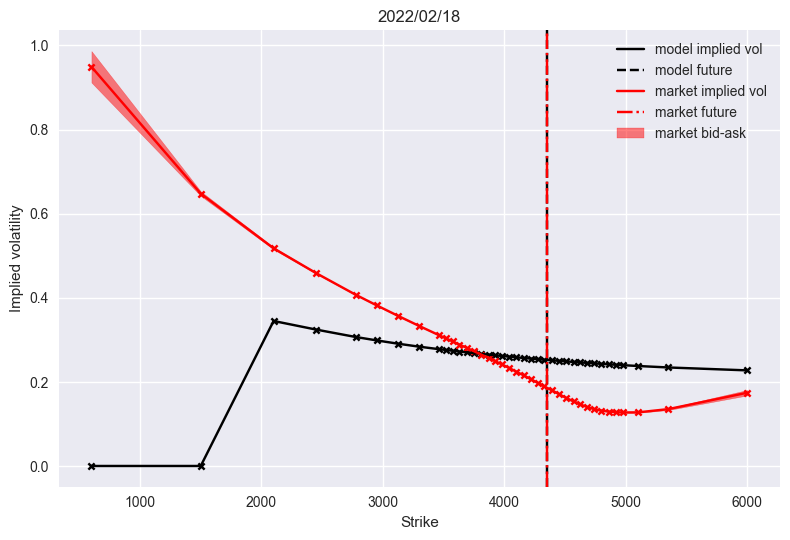

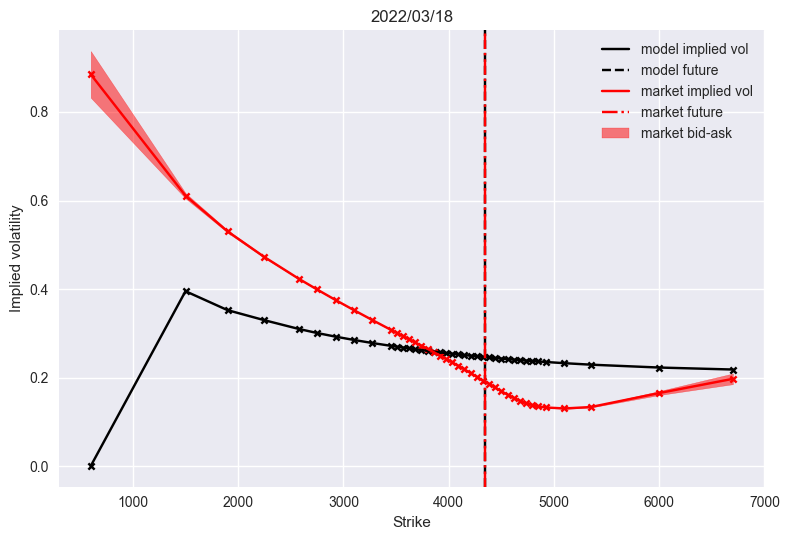

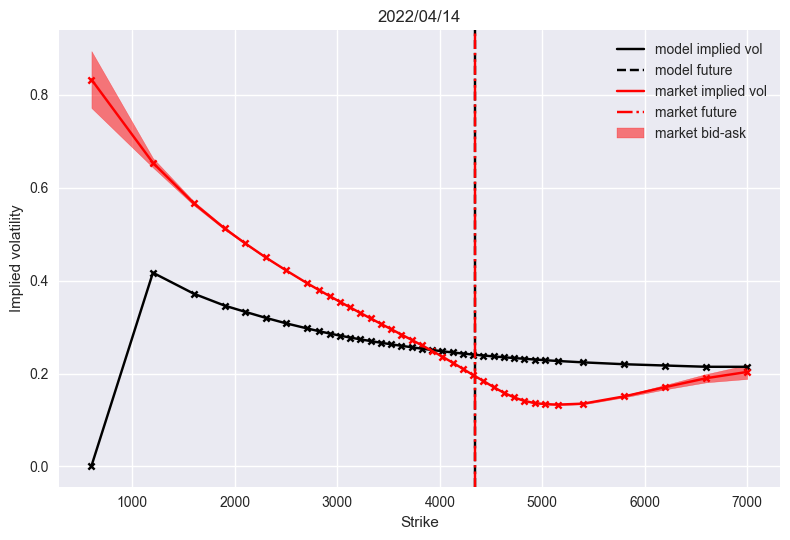

In [129]:
for i, maturity in enumerate(maturities["spx"]):
    smile_model = smiles[maturity]["spx"]["model"]
    smile_market = smiles[maturity]["spx"]["market"]
    plot_smile(smile_model, smile_market)
    plt.title(maturity)
    plt.tight_layout()
    str_date = maturity.datetime.strftime("%Y-%m-%d")
    #plt.savefig(f"images/spx-{str_date}.pdf")
    plt.show()

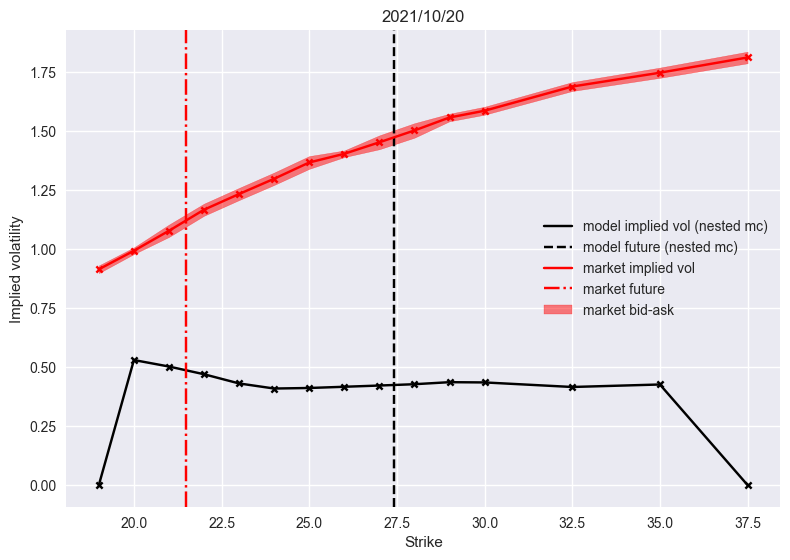

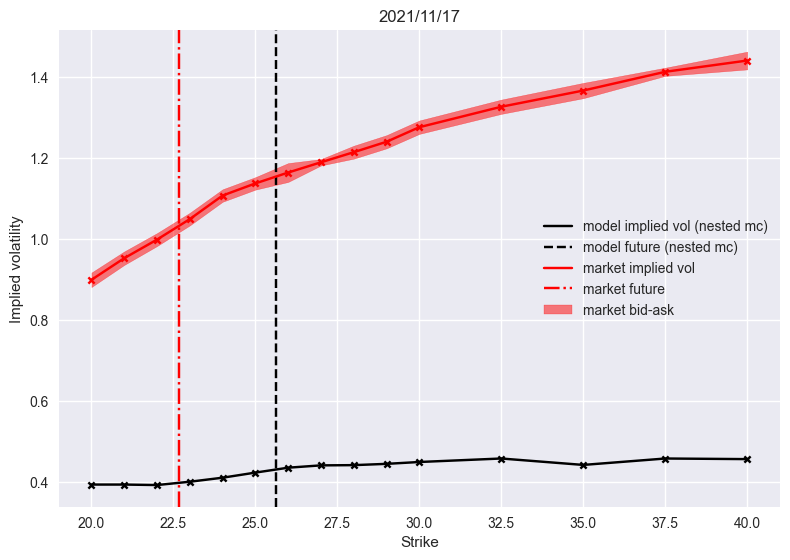

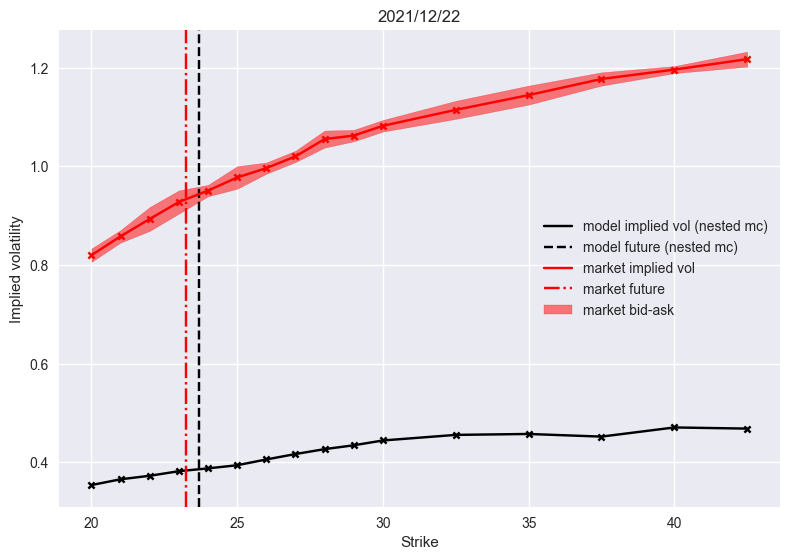

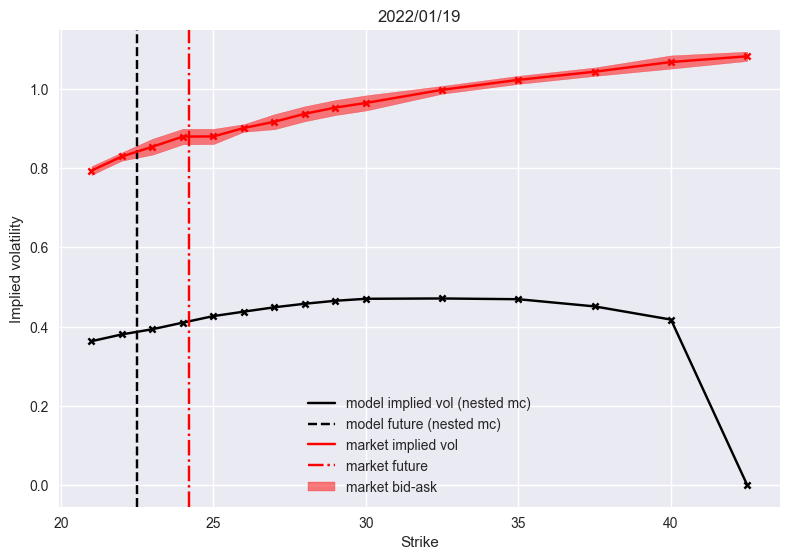

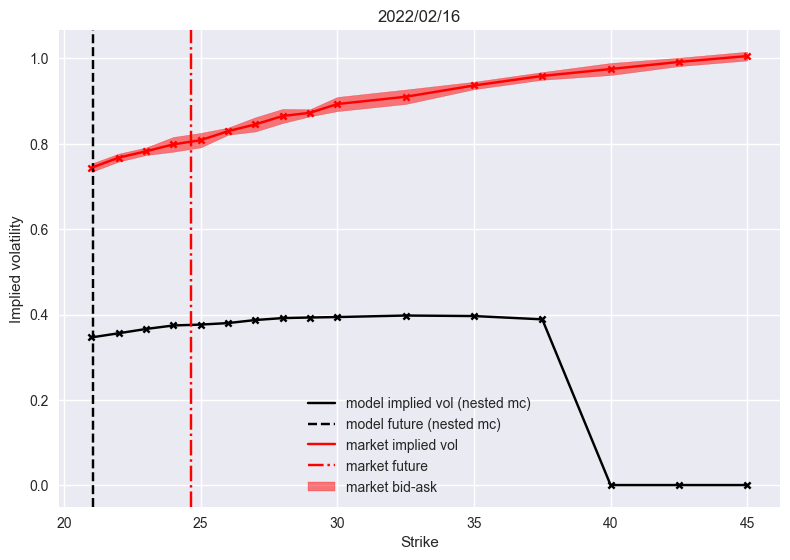

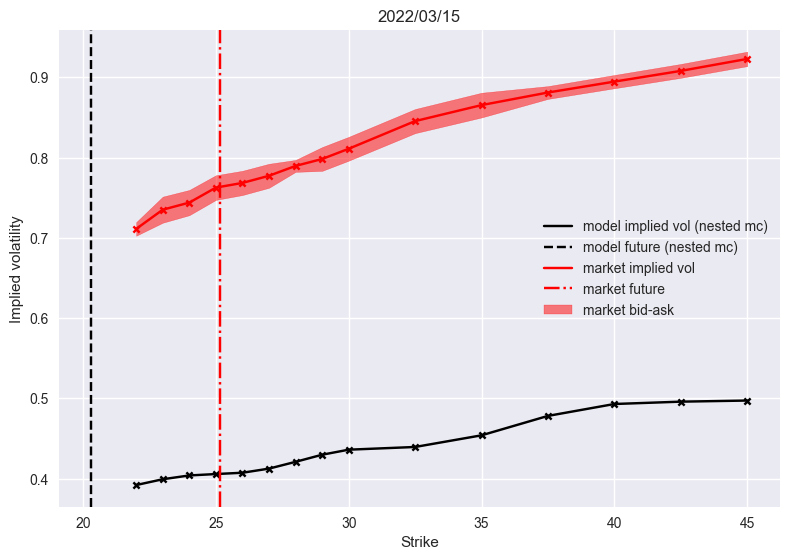

In [130]:
for maturity in maturities["vix"]:
    smile_model = smiles[maturity]["vix_nested"]["model"]
    smile_market = smiles[maturity]["vix_nested"]["market"]["market"]
    smile_model_lstsq = smiles[maturity]["vix"]["model"]
    plot_smile_vix(smile_model, smile_market, smile_model_lstsq)
    plt.tight_layout()
    plt.title(maturity)
    str_date = maturity.datetime.strftime("%Y-%m-%d")
    plt.savefig(f"images/vix-{str_date}.pdf")
    plt.show()

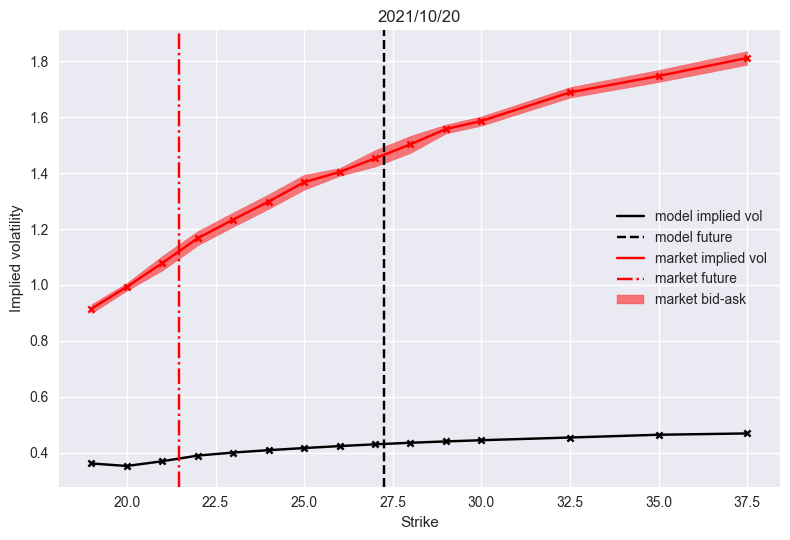

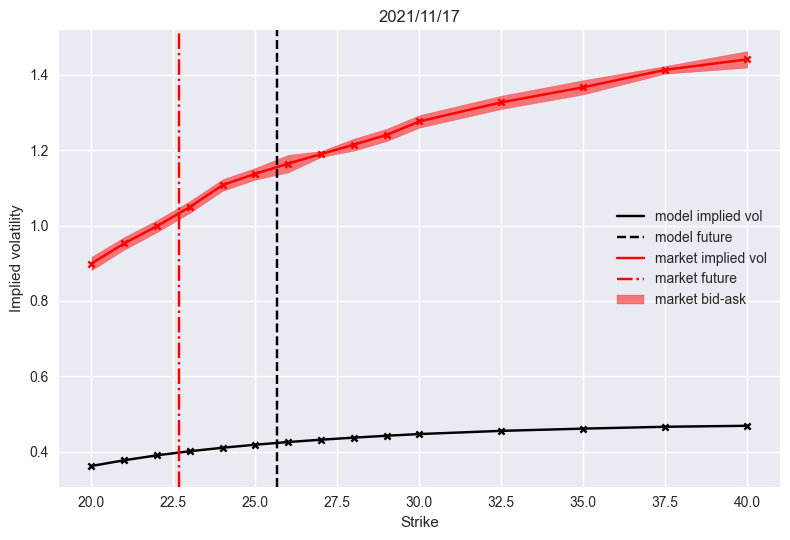

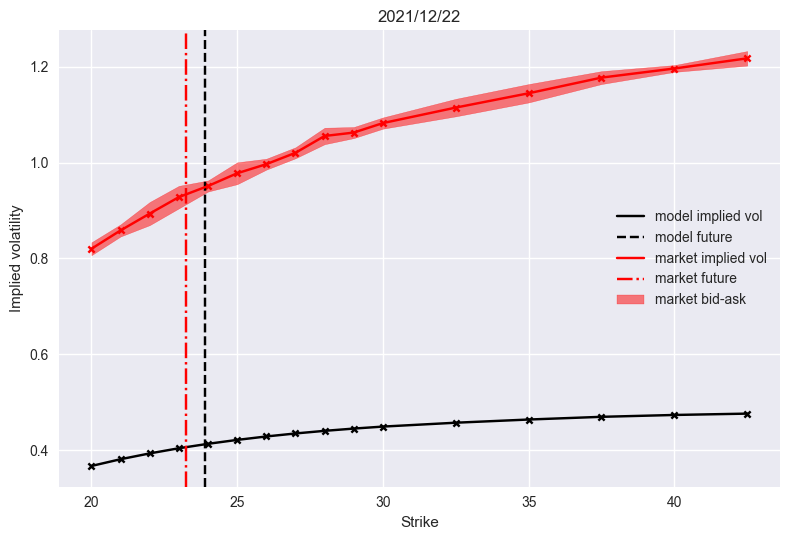

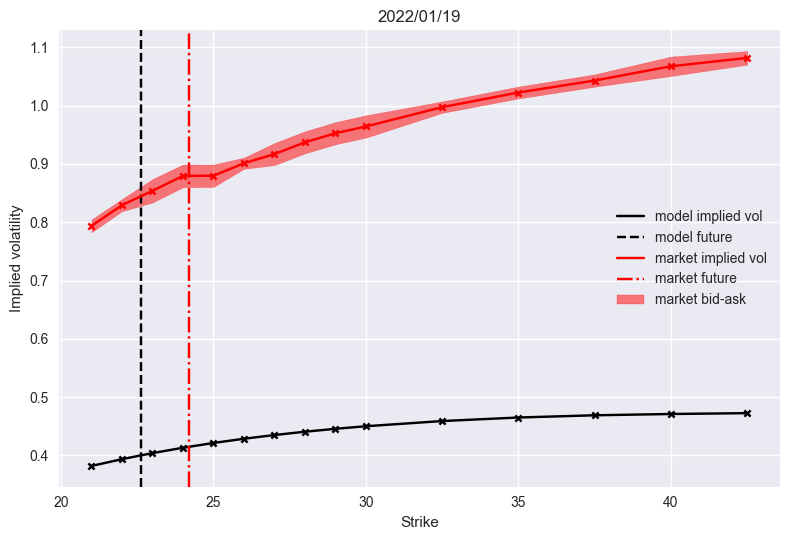

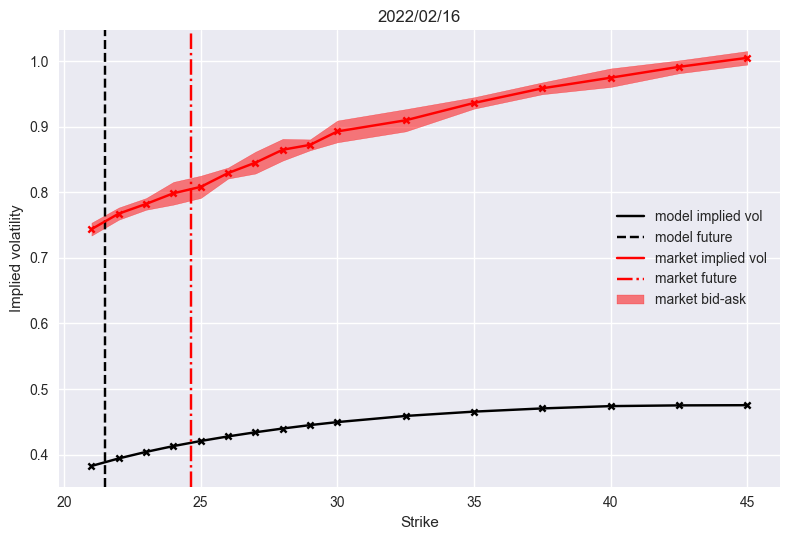

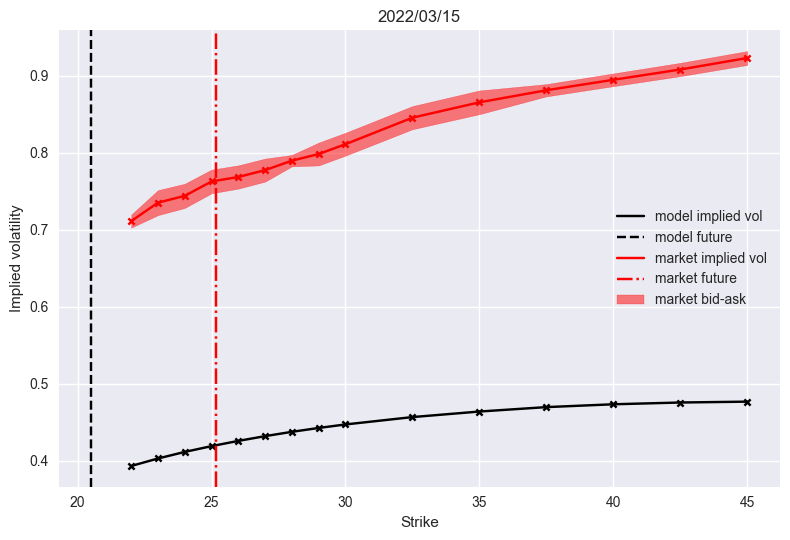

In [131]:
for maturity in maturities["vix"]:
    smile_model = smiles[maturity]["vix"]["model"]
    smile_market = smiles[maturity]["vix"]["market"]
    plot_smile(smile_model, smile_market)
    plt.title(maturity)
    plt.tight_layout()
    plt.show()

In [132]:
xy = output["XY"].cpu().numpy()[len(t) // 2, :5000]
qmX, qmY = np.quantile(xy, axis=[0], q=0.01)
qMX, qMY = np.quantile(xy, axis=[0], q=0.99)

In [133]:
x, y = xy.T
xy = xy[(qmX < x) & (x < qMX) & (qmY < y) & (y < qMY)]
x, y = xy.T

In [134]:
from src.vix import tXYfy
n_grid = 100
gridX = torch.linspace(qmX, qMX, n_grid)
gridY = torch.linspace(qmY, qMY, n_grid)
gridXX, gridYY = torch.meshgrid([gridX, gridY], indexing="ij")
gridXY = torch.stack([gridXX.ravel(), gridYY.ravel()], axis=1)[None, :, :]

t0 = Datetime("2021/11/13", T0=T0.string)
t0 = torch.tensor([t0.t])

tXY = tXYfy(t0, gridXY, device="cuda:0" if torch.cuda.is_available() else "cpu")[0]

txy = tXYfy(t0, torch.tensor(xy[None, :]), device="cuda:0" if torch.cuda.is_available() else "cpu")[0]

with torch.no_grad():
    Phi = model["nets"]["phi"](tXY).cpu().numpy()
    phi = model["nets"]["phi"](txy).cpu().numpy()

In [135]:
SigmaX, SigmaY, Rho, MuY = Phi[:, 0], Phi[:, 1], Phi[:, 2], Phi[:, [3]]
Rho = np.tanh(Rho)
SigmaX = 1 + np.tanh(SigmaX)
SigmaY = 1. * (1 + np.tanh(SigmaY))

sigmaX, sigmaY, rho, muY = phi[:, 0], phi[:, 1], phi[:, 2], phi[:, [3]]
rho = np.tanh(rho)
sigmaX = 1 + np.tanh(sigmaX)
sigmaY = (1 + np.tanh(sigmaY))

In [136]:
dlogSigmaXdX, dlogSigmaXdY = np.gradient(np.log(SigmaX).reshape((n_grid, n_grid)), gridX[1] - gridX[0], gridY[1] - gridY[0])
dlogSigmaXdXdX, dlogSigmaXdXdY =  np.gradient(dlogSigmaXdX, gridX[1] - gridX[0], gridY[1] - gridY[0])

In [137]:
from mpl_toolkits.mplot3d import Axes3D
cmhot = plt.get_cmap("viridis")

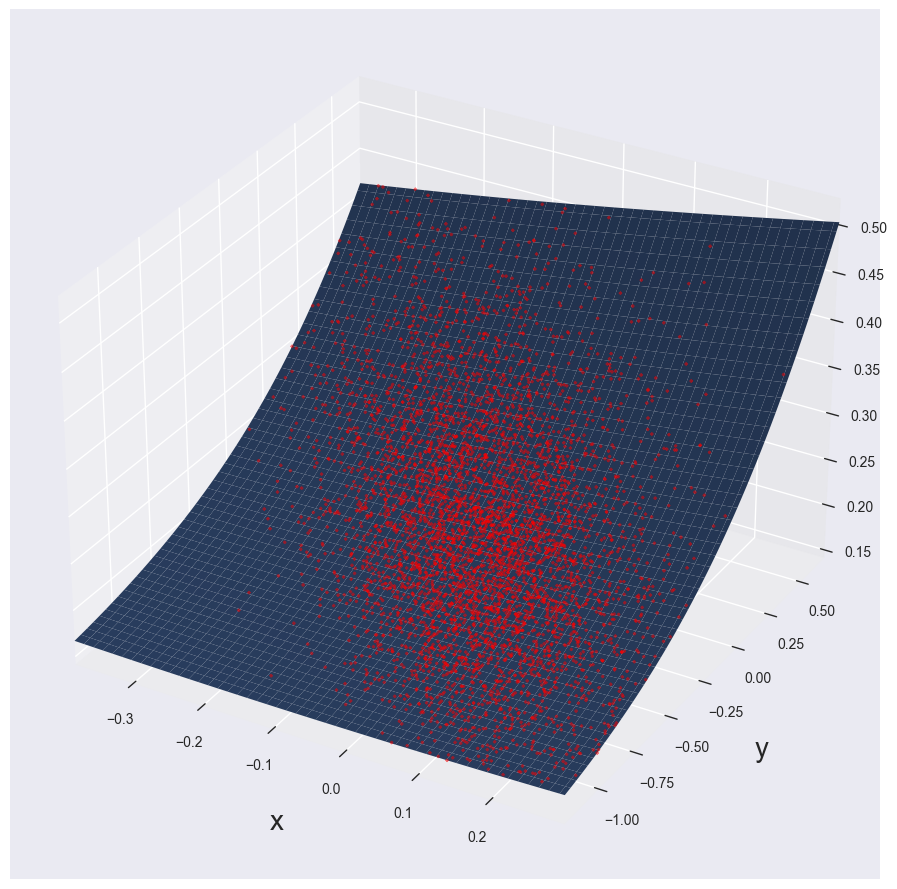

In [138]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.set_xlim3d(qmX, qMX)
ax.set_ylim3d(qmY, qMY)
ax.plot_surface(gridXX, gridYY, SigmaX.reshape((n_grid, n_grid)), alpha=1)
ax.scatter3D(x, y, sigmaX, color="red", s=2, marker="x", alpha=0.5)
ax.set_xlabel("x", fontsize=20, labelpad=20)
ax.set_ylabel("y", fontsize=20, labelpad=20)
plt.tight_layout()
plt.savefig("images/sigmaX.pdf")
plt.show()

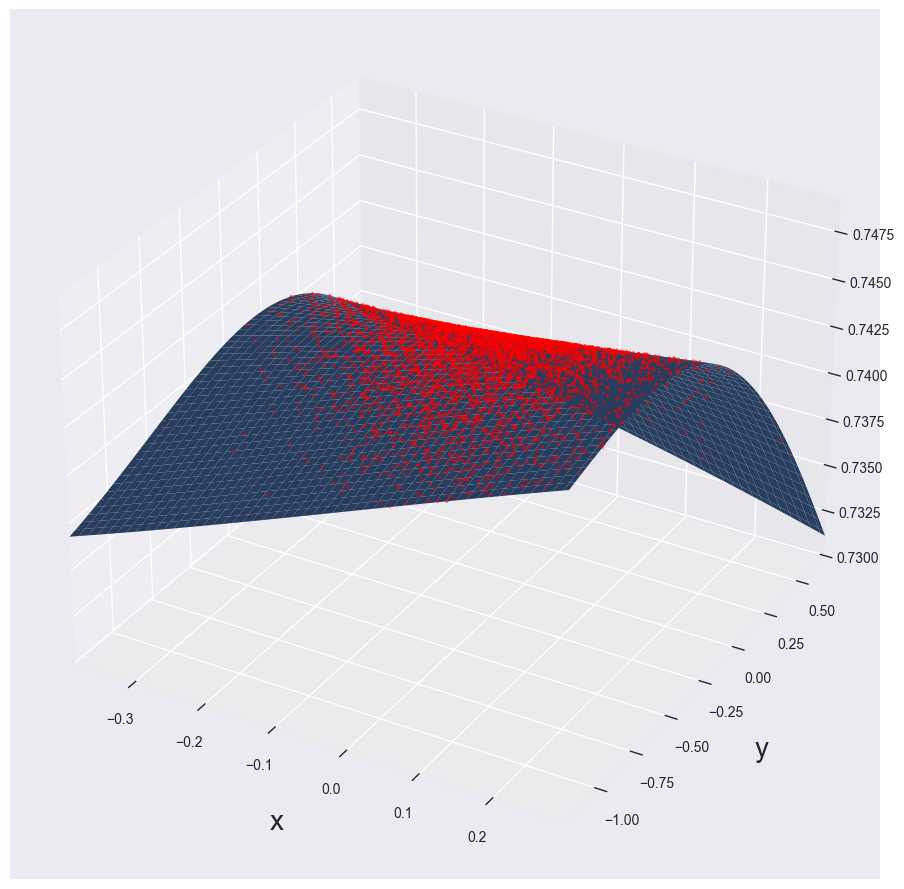

In [139]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.set_xlim3d(qmX, qMX)
ax.set_ylim3d(qmY, qMY)
ax.plot_surface(gridXX, gridYY, SigmaY.reshape((n_grid, n_grid)), alpha=1)
ax.scatter3D(x, y, sigmaY, color="red", s=2, marker="x", alpha=0.5)
ax.set_xlabel("x", fontsize=20, labelpad=20)
ax.set_ylabel("y", fontsize=20, labelpad=20)
plt.tight_layout()
plt.savefig("images/sigmaY.pdf")

plt.show()

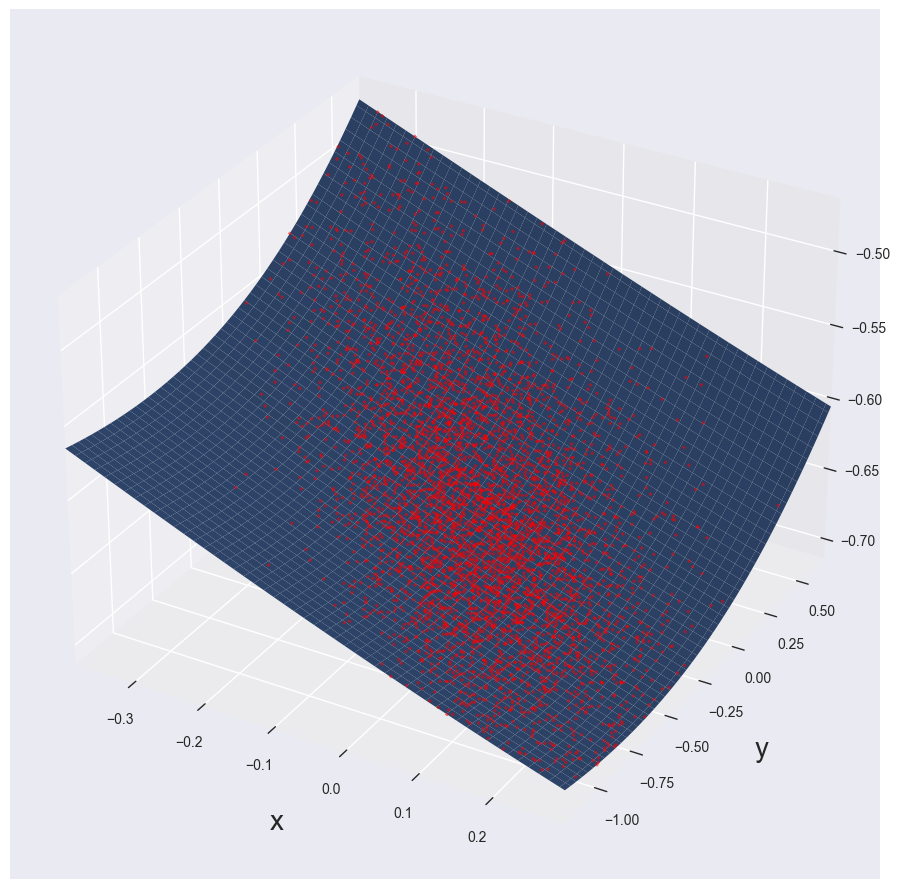

In [140]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.set_xlim3d(qmX, qMX)
ax.set_ylim3d(qmY, qMY)
ax.plot_surface(gridXX, gridYY, Rho.reshape((n_grid, n_grid)), alpha=1)
ax.scatter3D(x, y, rho, color="red", s=2, marker="x", alpha=0.5)
ax.set_xlabel("x", fontsize=20, labelpad=20)
ax.set_ylabel("y", fontsize=20, labelpad=20)
plt.tight_layout()
plt.savefig("images/rho.pdf")

plt.show()

In [141]:
Z = gridYY

In [142]:
%%script skipskip

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.set_xlim3d(qmX, qMX)
ax.set_ylim3d(qmY, qMY)
ax.plot_surface(gridXX, gridYY, MuY.reshape((n_grid, n_grid)), alpha=1)
ax.scatter3D(x, y, muY, color="red", s=2, marker="x", alpha=0.5)
ax.set_xlabel("x", fontsize=20, labelpad=20)
ax.set_ylabel("y", fontsize=20, labelpad=20)
plt.tight_layout()
ax.view_init(azim=30)
#ax.plot_surface(gridXX, gridYY, 100gridYY, alpha=1)
plt.savefig("images/muY_rotated.pdf")
plt.show()

Couldn't find program: 'skipskip'


In [143]:
from sklearn.linear_model import LinearRegression

In [144]:
idx = (gridX ** 2).argmin()

In [145]:
m = MuY.reshape((n_grid, n_grid))[idx, :]

In [146]:
i = (m ** 2).argmin()
slope = - (m[i] - m[i - 1]) / (gridY[1] - gridY[0])
tangent = slope * (gridY[i] - gridY)

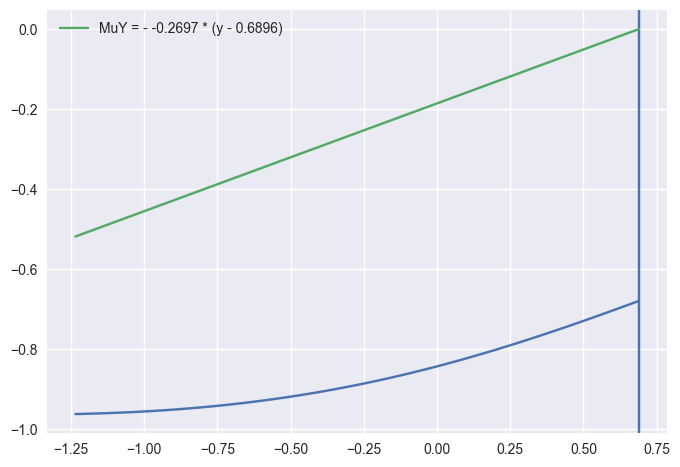

In [147]:
plt.plot(gridY, m)
plt.axvline(gridY[(m ** 2).argmin()])
plt.plot(gridY, tangent, label=f"MuY = - {slope:.4f} * (y - {gridY[i]:.4f})")
plt.legend()
plt.savefig("images/mean-reversion-13-nov.pdf")
plt.show()